# Training with LighGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms,  which has following merits to orthodox decision tree model.(e.g. random forest)



- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.

We will first implements a naive lightGBM model then use the technics from above. Hoping it achieves better than random-forest.

In [1]:
import os
import logging
import json

import lightgbm as lgb
import numpy as np
import pandas as pd


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from data import DATA_DIR
from lama.util.decorators import enable_logging

logger = logging.getLogger()

OUT_DIR = os.path.join(DATA_DIR, "pre")
RESULT_DIR = os.path.join(DATA_DIR, "result")


In [2]:
train = pd.read_csv(os.path.join(OUT_DIR, "train_groupby.csv"))
test = pd.read_csv(os.path.join(OUT_DIR, "test_groupby.csv"))

features = train.columns.tolist()
features.remove("target")
features.remove("card_id")
label = 'target'

In [3]:
# parameters see <a href="https://lightgbm.readthedocs.io/en/latest/Parameters.html" />
# randomly picked parameters
param_init = {
    'num_leaves': 31,
    'learning_rate': 0.3,
    'min_child_samples': 20,
    'bagging_seed': 2022,
    'bagging_fraction': 0.7,
    # to enable bagging, bagging_freq should be set
    # to a non zero value as well
    'bagging_freq': 1,
    'metric': 'rmse',
    'lambda_l1': 0.2,
    'lambda_l2': 1.0,
    'force_col_wise': True,
    'objective': 'regression',
    'early_stopping_round': 30,
    'num_boost_round': 1000,
    'verbose_evalutaion': 50,
}


In [4]:
n_split=5

def dump(model, filename):
    with open(os.path.join(RESULT_DIR, filename), 'w') as file:
        file.write(json.dumps(model))

@enable_logging("perform_lgb_kfold.log")
def perform_lgb_kfold(train, test, features, label, params, n_splits=5, random_state=22):
    """
    Homemade kfold
    """
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    prediction_test = 0
    eval_results= {}
    predictions = np.zeros(train.shape[0])
    logger.info("Start Loop")
    for i, (train_index, validation_index) in enumerate(kf.split(train[features])):
        train_lgb = lgb.Dataset(train[features].loc[train_index],
                                train[label].loc[train_index])
        validation_lgb = lgb.Dataset(train[features].loc[validation_index],
                                     train[label].loc[validation_index])
        bst = lgb.train(params, train_lgb,
                        valid_sets=[train_lgb, validation_lgb],
                        valid_names=['train', 'valid'],
                        evals_result=eval_results,
                        callbacks=[lgb.early_stopping(params['early_stopping_round']),
                                   lgb.log_evaluation(params['verbose_evalutaion']),
                                   lgb.record_evaluation(eval_results)],
                        num_boost_round=params['num_boost_round'])
        logger.debug(f"evalute results in {i} round: {eval_results}")

        prediction_test += bst.predict(test[features])
        validation_pre = bst.predict(train[features].loc[validation_index])
        score = np.sqrt(mean_squared_error(train[label].loc[validation_index].values, validation_pre))
        logger.debug(f'CV Score in {i} round: {score}')
        predictions[validation_index] = validation_pre
        dump(bst.dump_model(i), f"lightGBM_{i}.json")
    return prediction_test, predictions

In [5]:
prediction_test, predictions = perform_lgb_kfold(train, test, features, label, param_init)
test['target'] = prediction_test / n_split
test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, "submission_light_gbm_kfold.csv"), index=False)


prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_train.csv"))
prediction_csv['target_2'] = predictions
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_train.csv"), index=False)

prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_test.csv"))
prediction_csv['target_2'] = prediction_test
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_test.csv"), index=False)


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22838
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.028512
Training until validation scores don't improve for 30 rounds


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22848
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.029306
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.53906	valid's rmse: 1.60735


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22831
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.031163
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.53828	valid's rmse: 1.61286


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22839
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.035700
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.54419	valid's rmse: 1.59618
Early stopping, best iteration is:
[26]	train's rmse: 1.57032	valid's rmse: 1.59131


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22846
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.029715
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.54264	valid's rmse: 1.60289


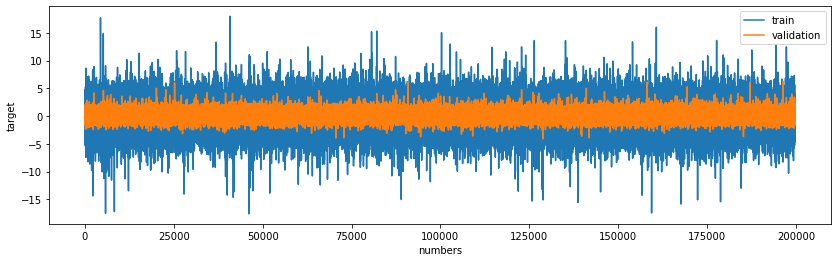

In [6]:
import matplotlib.pyplot as plt

def plot_train_validation(train, validation, target):
    plt.figure(figsize=(14,4))
    
    train_target = train[target]
    
    plt.plot(train_target, label='train')
    plt.plot(validation, label='validation')
    plt.xlabel("numbers")
    plt.ylabel(target)
    plt.legend()
    plt.show()

plot_train_validation(train, predictions, 'target')

The result is better than random forest because gradient boosting is a boosting algorithms. And lightGBM itself performs better.

### 2. Tunning Hyperparameters with algorithms


In [7]:
from hyperopt import hp, fmin, tpe
from numpy.random import RandomState

PARAMETER_SPACE = {
    'learning_rate': hp.uniform('learning_rate', 1E-2, 5E-1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'force_col_wise': True,
    'feature_pre_filter': False,
    'num_leaves': hp.choice('num_leaves', list(range(10, 500, 10))),
    'lambda_l1': hp.randint('lambda_l1', 0, 10),
    'lambda_l2': hp.randint('lambda_l2', 0, 10),
    'bagging_freq': hp.randint('bagging_freq', 1, 10),
    'min_child_samples': hp.choice('min_child_samples', list(range(10, 50, 5)))
}

def param_limits(params):
    """
    setting parameters that should stay unchanged during training
    """
    params['feature_pre_filter'] = False
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['bagging_seed'] = 2022
    params['early-stopping-round'] = 30,
    params['num_boost_round'] = 1000,
    params['verbose_evalutaion'] = 50,
    return params

# Running the following step can be time consuming and error-prone.

# The Log data shows the function has been finished successfully but lightGBM refuses to
# release the process. So each time we have to quit the programme violently and fetch result from log.

@enable_logging("param_opt.log")
def param_opt(train, param_space, random_state=2022):

    if not isinstance(train, lgb.Dataset):
        train = lgb.Dataset(train.values)

    def hyperopt_objective(params):
        """
        input hyperparameters,
        output mse
        fmin fn requires only one parameters
        so we must define inner function here or
        use functools.partial to enable currying
        """
        params = param_limits(params)
        logger.debug(params)
        # using cv provided by lgb lib
        res = lgb.cv(params, train, num_boost_round=params['num_boost_round'],
                nfold=n_split, stratified=False, shuffle=True,
                metrics='rmse',
                callbacks=[lgb.early_stopping(params['early_stopping_round']),
                lgb.log_evaluation(params['verbose_evalutaion'])], show_stdv=False, seed=2022)
        return min(res['rmse-mean'])


    param_best = fmin(
        hyperopt_objective,
        space=param_space,
        max_evals=param_init['early_stopping_round'],
        timeout=10000,
        algo=tpe.suggest,
        rstate=RandomState(random_state)
    )
    return param_best


# best_clf = param_opt(train[features], PARAMETER_SPACE)

/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22838
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.028512
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.56766	valid's rmse: 1.60421
Early stopping, best iteration is:
[53]	train's rmse: 1.56572	valid's rmse: 1.60377


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22848
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.029306
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.56761	valid's rmse: 1.60315


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22831
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.031163
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.56618	valid's rmse: 1.60936
Early stopping, best iteration is:
[33]	train's rmse: 1.57698	valid's rmse: 1.6071


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22839
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.035700
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.57087	valid's rmse: 1.59376


/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Total Bins 22846
[LightGBM] [Info] Number of data points in the train set: 159768, number of used features: 148
[LightGBM] [Warning] Unknown parameter: verbose_evalutaion
[LightGBM] [Info] Start training from score -0.029715
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 1.56808	valid's rmse: 1.59922
Early stopping, best iteration is:
[51]	train's rmse: 1.56723	valid's rmse: 1.59882


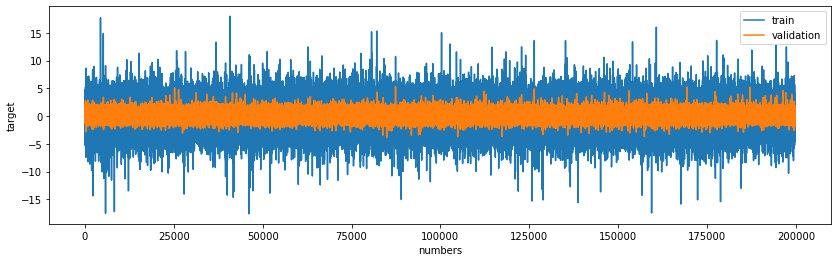

In [8]:
best_clf = {'bagging_fraction': 0.5500662362965777,
            'bagging_freq': 8,
            'feature_fraction': 0.6082106866315594,
            'feature_pre_filter': False,
            'force_col_wise': True,
            'lambda_l1': 9,
            'lambda_l2': 0,
            'learning_rate': 0.29595811580503384,
            'min_child_samples': 30,
            'num_leaves': 20,
            'objective': 'regression',
            'metric': 'rmse',
            'bagging_seed': 2022,
            'early_stopping_round': 30,
            'num_boost_round': 1000,
            'verbose_evalutaion': 50,
}

prediction_test, predictions = perform_lgb_kfold(train, test, features, label, best_clf)
test['target'] = prediction_test / n_split
test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, "submission_light_gbm_best_params.csv"), index=False)
plot_train_validation(train, predictions, 'target')

In [9]:
prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_train.csv"))
prediction_csv['target_3'] = predictions
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_train.csv"), index=False)

prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_test.csv"))
prediction_csv['target_3'] = prediction_test
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_test.csv"), index=False)